# 1.1 This is how the data pre-processed and cleaned

In [44]:
import numpy as np
import pandas as pd
import requests
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics

In [45]:
## We use the 'central_london.csv' as our data(sources: TfL officional website)

central_london = pd.read_csv('central_london.csv')
#inner_london = pd.read_csv('inner_london.csv')
#outerlondon = pd.read_csv('outer_london.csv')
count_sites_list = pd.read_csv('count_sites_list.csv',usecols=('UnqID','Borough'))
infrastructure = pd.read_csv('infrastructure.csv',usecols=('year','BOROUGH','infrastructure'))

In [46]:
## Data cleaning and pre-processing

df = pd.merge(central_london,count_sites_list,'left',left_on='Site ID',right_on='UnqID')
year = df['Survey wave (calendar quarter)'].str.split(' ',expand=True)
other_predictors = df.iloc[:,2:]
df = pd.concat([year,other_predictors],axis=1)
df.rename(columns={0: 'Year', 1: 'Quarter', 2: 'Month'}, inplace=True)
infrastructure['year']=infrastructure['year'].astype(str)

    #choose year from 2017 and set Quarter to Q3 to get a complete data
df = df[df['Year'].astype(int)>2016]
df = df[df['Quarter']=='Q3']
    #merge with the infrastructure data
pick_agg_cols = {'Number of normal cycles':['sum'],'Number of cycle hire bikes':['sum'], 'Total cycles':['sum']}
df_grouped = df.groupby(['Borough','Year','Period','Weather']).agg(pick_agg_cols).reset_index()

df_grouped=pd.merge(df_grouped, infrastructure,'left',left_on = ['Year','Borough'],right_on=['year','BOROUGH'])
df_grouped=df_grouped.drop(columns=['year', 'BOROUGH'])
df_grouped.columns = ['Borough','Year','Period','Weather','Normal_cycles','Hire_cycles','Total_cycles','Infras']
df_grouped['Year']=df_grouped['Year'].astype(int)


# Modelling

    #Create the training and testing data sets
mask = np.random.rand(len(df_grouped)) < 0.8
df_train = df_grouped[mask]
df_test = df_grouped[~mask]
#print('Training data set length='+str(len(df_train)))
#print('Testing data set length='+str(len(df_test)))

expr_train = """df_train['Total_cycles'] ~ df_train['Borough'] + df_train['Year'] + df_train['Period'] + df_train['Infras']"""
expr_test = """df_test['Total_cycles'] ~ df_test['Borough'] + df_test['Year'] + df_test['Period'] +df_test['Infras']"""

    #Set up the X and y matrices
y_train, X_train = dmatrices(expr_train, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr_test, df_test, return_type='dataframe')

    #Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Training summary.
    #Note:the training result may be different because each time the traing and test set are randomly generated. 
print(poisson_training_results.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     df_train['Total_cycles']   No. Observations:                  213
Model:                                  GLM   Df Residuals:                      199
Model Family:                       Poisson   Df Model:                           13
Link Function:                          log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:            -7.6990e+05
Date:                      Thu, 18 Mar 2021   Deviance:                   1.5381e+06
Time:                              10:55:51   Pearson chi2:                 2.14e+06
No. Iterations:                           7                                         
Covariance Type:                  nonrobust                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

C:\Users\xingy\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [47]:
# Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test


             mean    mean_se  mean_ci_lower  mean_ci_upper
0     8370.240307  34.138933    8303.595958    8437.419542
6     2789.850417  13.290876    2763.922017    2816.022052
9     3372.874484  15.262126    3343.093522    3402.920741
11    7129.441115  30.240190    7070.417116    7188.957848
21    5112.297366  20.884524    5071.527884    5153.394590
22   10806.160505  42.146500   10723.869812   10889.082665
52   18949.190087  60.076022   18831.808319   19067.303514
55    1353.602934  11.045107    1332.127109    1375.424980
58    6315.876717  24.245722    6268.534301    6363.576682
62    7635.771183  27.343573    7582.366398    7689.552114
100    114.462839   2.312585     110.018826     119.086361
107    208.451980   4.192372     200.394925     216.832977
123    592.096340   5.101237     582.182042     602.179474
131  12441.168316  57.232316   12329.499216   12553.848810
135   5013.296826  24.223346    4966.044040    5060.999230
170   1340.656036   6.383254    1328.203283    1353.2255

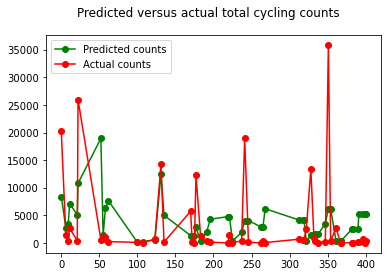

Text(0, 0.5, 'Actual counts')

<Figure size 432x288 with 0 Axes>

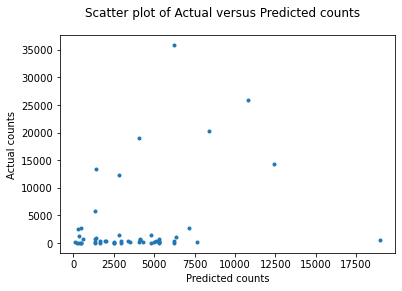

In [48]:
# Plot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual total cycling counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')

plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')


In [50]:
df_grouped_without_weather=df_grouped.copy().drop(columns=['Weather'])

In [52]:
pick_agg_cols_new = {'Normal_cycles':['sum'],'Hire_cycles':['sum'], 'Total_cycles':['sum'],'Infras':['mean']}
#df_grouped_without_weather = df_grouped_without_weather.groupby(['Borough','Year','Quarter','Period']).agg(pick_agg_cols_new).reset_index()
df_grouped_without_weather = df_grouped_without_weather.groupby(['Borough','Year','Period']).agg(pick_agg_cols_new).reset_index()



In [53]:
df_grouped_without_weather.to_csv('df_grouped_without_weather_2.0.csv')

In [54]:
df_grouped_without_weather

,Borough,Year,Period,Normal_cycles,Hire_cycles,Total_cycles,Infras
,,,,sum,sum,sum,mean
0,Camden,2017,AM peak (07:00-10:00),20434.0,2624.0,23058.0,2344.0
1,Camden,2017,Early Morning (06:00-07:00),1269.0,149.0,1418.0,2344.0
2,Camden,2017,Evening (19:00-22:00),8887.0,907.0,9794.0,2344.0
3,Camden,2017,Inter-peak (10:00-16:00),12496.0,2022.0,14518.0,2344.0
4,Camden,2017,PM peak (16:00-19:00),20740.0,2700.0,23440.0,2344.0
...,...,...,...,...,...,...,...
155,Westminster,2020,AM peak (07:00-10:00),29794.0,4108.0,33892.0,NaN
156,Westminster,2020,Early Morning (06:00-07:00),3627.0,363.0,3990.0,NaN
157,Westminster,2020,Evening (19:00-22:00),15272.0,3279.0,18525.0,NaN


In [62]:
#Create the training and testing data sets.
mask = np.random.rand(len(df_grouped_without_weather)) < 0.8
df_train = df_grouped_without_weather[mask]
df_test = df_grouped_without_weather[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))


expr_train = """df_train['Total_cycles'] ~ df_train['Borough'] + df_train['Year'] + df_train['Period'] + df_train['Infras']"""
expr_test = """df_test['Total_cycles'] ~ df_test['Borough'] + df_test['Year'] + df_test['Period'] +df_test['Infras']"""

#expr_train = """df_train['Total_cycles'] ~ df_train['Borough'] + df_train['Year'] + df_train['Period']"""
#expr_test = """df_test['Total_cycles'] ~ df_test['Borough'] + df_test['Year'] + df_test['Period']"""


#Set up the X and y matrices
y_train, X_train = dmatrices(expr_train, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr_test, df_test, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

Training data set length=133
Testing data set length=27
                    Generalized Linear Model Regression Results                     
Dep. Variable:     df_train['Total_cycles']   No. Observations:                   65
Model:                                  GLM   Df Residuals:                       51
Model Family:                       Poisson   Df Model:                           13
Link Function:                          log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -2318.1
Date:                      Thu, 18 Mar 2021   Deviance:                       3979.5
Time:                              11:00:10   Pearson chi2:                 4.02e+03
No. Iterations:                           8                                         
Covariance Type:                  nonrobust                                         
                                                        coef    std err          z      P>|z| 

In [63]:
#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test

             mean     mean_se  mean_ci_lower  mean_ci_upper
25   43671.240200  173.033261   43333.414668   44011.699407
40     521.910195   14.191695     494.823197     550.479956
41      39.045335    1.085647      36.974447      41.232210
42     206.771361    5.627145     196.031338     218.099800
44     511.838611   13.889980     485.326079     539.799476
45     579.628117   15.716421     549.628698     611.264940
60   12918.726816   64.696096   12792.545071   13046.153179
64   12669.427122   64.139803   12544.337044   12795.764578
83    7373.313381   37.107263    7300.941998    7446.402153
87    6816.538286   35.227534    6747.842088    6885.933844
88    8287.064445   43.401163    8202.434824    8372.567243
104  24581.230074  100.870651   24384.320149   24779.730100
107  11208.725435   50.332447   11110.508498   11307.810611
148  21084.650093   85.012729   20918.684842   21251.932083
149  42931.120018  144.606687   42648.629623   43215.481536


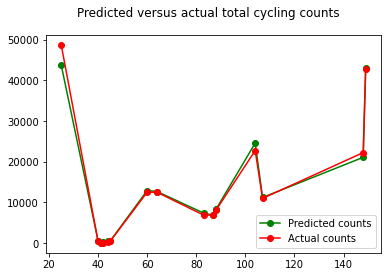

Text(0, 0.5, 'Actual counts')

<Figure size 432x288 with 0 Axes>

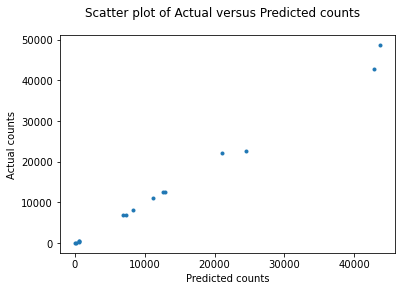

In [64]:
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual total cycling counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
#plt.ylim((0, 14000))
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
#plt.xlim((0,14000))
#plt.ylim((0,14000))
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')


In [58]:
pred_2021 = pd.read_csv('prediction_set.csv')

In [66]:
expr_pred = """pred_2021['Total_cycles'] ~ pred_2021['Borough'] + pred_2021['Year'] + pred_2021['Period'] + pred_2021['Infras']"""
#Set up the X and y matrices
y_pred, X_pred = dmatrices(expr_pred, pred_2021, return_type='dataframe')

In [67]:
poisson_predictions_2021 = poisson_training_results.get_prediction(X_pred)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame_2021 = poisson_predictions_2021.summary_frame()
print(predictions_summary_frame_2021)

            mean      mean_se  mean_ci_lower  mean_ci_upper
0   29795.788254   739.924520   28380.289954   31281.886095
1    2229.093310    56.279789    2121.471731    2342.174497
2   11804.551299   288.937318   11251.613804   12384.661774
3   14351.137375   353.818305   13674.154442   15061.636522
4   29220.802732   720.467056   27842.289693   30667.567996
5   50475.320075  1147.027781   48276.516938   52774.269940
6    3776.177939    87.510372    3608.497679    3951.649994
7   19997.407019   446.995066   19140.226592   20892.975616
8   24311.431074   547.685770   23261.340090   25408.926509
9   49501.270387  1114.156656   47365.029137   51733.859654
10    647.386400    23.514779     602.900563     695.154684
11     48.432506     1.771152      45.082598      52.031332
12    256.482759     9.243175     238.991475     275.254192
13    311.813572    11.260293     290.506733     334.683132
14    634.893432    22.957191     591.455577     681.521463
15  16024.611352   386.457154   15284.79

In [68]:
pred_2021['Totle_cycles_predicted']=predictions_summary_frame_2021['mean']
pred_2021

,Unnamed: 0,Borough,Year,Period,Normal_cycles,Hire_cycles,Total_cycles,Infras,Infra,Totle_cycles_predicted
0,10,Camden,2021,AM peak (07:00-10:00),0,0,0,2344,0,29795.788254
1,11,Camden,2021,Early Morning (06:00-07:00),0,0,0,2344,0,2229.093310
2,12,Camden,2021,Evening (19:00-22:00),0,0,0,2344,0,11804.551299
3,13,Camden,2021,Inter-peak (10:00-16:00),0,0,0,2344,0,14351.137375
4,14,Camden,2021,PM peak (16:00-19:00),0,0,0,2344,0,29220.802732
5,70,City of London,2021,AM peak (07:00-10:00),0,0,0,743,0,50475.320075
6,71,City of London,2021,Early Morning (06:00-07:00),0,0,0,743,0,3776.177939
7,72,City of London,2021,Evening (19:00-22:00),0,0,0,743,0,19997.407019
8,73,City of London,2021,Inter-peak (10:00-16:00),0,0,0,743,0,24311.431074
9,74,City of London,2021,PM peak (16:00-19:00),0,0,0,743,0,49501.270387


In [178]:
#pred_2021.to_csv('total_cycles_prediction_2021.csv')